# Generate scRNA-Seq data using scBoolSeq

In [1]:
from IPython.display import HTML, display
display(HTML('<style>''.container { width:92.5% !important; }''</style>'))

import ipywidgets as widgets
from ipywidgets import HBox, VBox

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotnine as p9

from sklearn import metrics
from scipy.spatial import distance
import itertools

import bonesis
import scboolseq
from scboolseq import scBoolSeq

from colomoto_jupyter import tabulate

from sklearn.utils import Bunch

In [3]:
SEED = 1234
root = Path(".").resolve()
here = Path(".").resolve()

In [4]:
checkpoint_dir = here / "multilevel/"

### Experiment config

In [5]:
import mpbn

In [6]:
import booleantraces as btrace

In [7]:
confs = pd.read_csv(checkpoint_dir / "10_configurations.csv", index_col=0)
confs.head()

,DEFENDO,MESENDO,ES,MESO,ECTO
x0,0,0,0,0,1
x2,0,0,1,0,1
x3,0,0,1,0,0
x4,0,1,1,0,0
x7,0,0,0,0,0


In [8]:
confs.columns = ['stable3', 'bifurcation', 'init', 'stable2', 'stable1']

In [9]:
confs

,stable3,bifurcation,init,stable2,stable1
x0,0,0,0,0,1
x2,0,0,1,0,1
x3,0,0,1,0,0
x4,0,1,1,0,0
x7,0,0,0,0,0
x9,0,0,0,0,1
x10,0,1,1,1,1
x11,0,0,0,1,1
x17,0,1,0,0,1
x20,0,0,1,0,0


# computing graph layout...


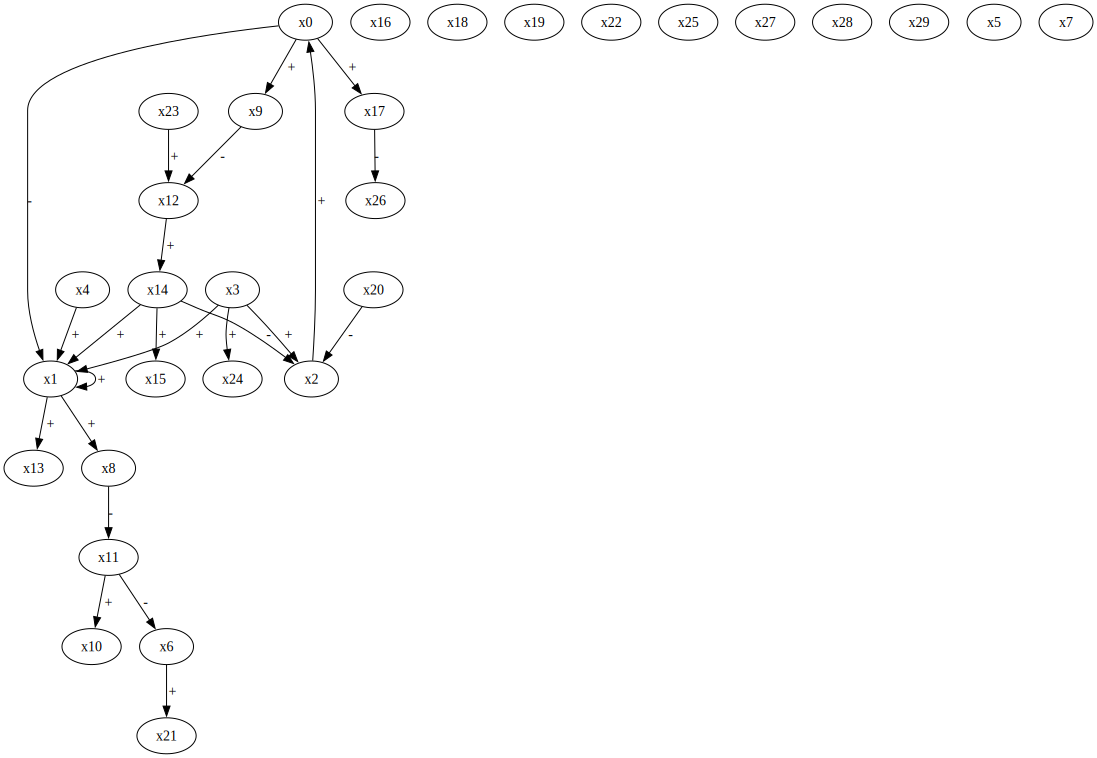

In [10]:
f = mpbn.load((checkpoint_dir/"10_bn.bnet").as_posix())
_ig = f.influence_graph()
bonesis.InfluenceGraph(_ig)

In [11]:
wcc = nx.induced_subgraph(_ig, max(nx.weakly_connected_components(_ig)))
isolated = [_x for _x in _ig.nodes() if _x not in wcc]
isolated

['x16', 'x18', 'x19', 'x22', 'x25', 'x27', 'x28', 'x29', 'x5', 'x7']

In [12]:
ig = bonesis.InfluenceGraph(wcc)

In [13]:
nx.nx_pydot.write_dot(ig, "multilevel_random_network_ig.dot")

In [14]:
[f.pop(i) for i in isolated]

[TRUE, TRUE, TRUE, FALSE, TRUE, FALSE, FALSE, FALSE, TRUE, FALSE]

In [15]:
confs = confs.loc[confs.index.difference(isolated), :]

In [16]:
confs.index.isin(f.keys()).all()

True

In [17]:
confs['bifurcation'] !=  confs['stable3']

x0     False
x1      True
x10     True
x11    False
x12    False
x13    False
x14    False
x15     True
x17     True
x2     False
x20    False
x21     True
x23     True
x24     True
x26    False
x3     False
x4      True
x6     False
x8      True
x9     False
dtype: bool

In [18]:
init_transient = btrace.labelled_trajectory(f, confs, start="init", stop="bifurcation", _trans_label="init_to_bifurcation")
init_transient.shape[0] - 2

Grounding...done in 0.0s


4

In [19]:
init_stable1 = btrace.labelled_trajectory(f, confs, start="init", stop="stable1", _trans_label="init_to_stable1")
init_stable1.shape[0] -  2

Grounding...done in 0.1s


12

In [20]:
transient_stable2 = btrace.labelled_trajectory(f, confs, start="bifurcation", stop="stable2", _trans_label="bifurcation_to_stable2")
transient_stable2.shape[0] - 2

Grounding...done in 0.0s


7

In [21]:
transient_stable3 = btrace.labelled_trajectory(f, confs, start="bifurcation", stop="stable3", _trans_label="bifurcation_to_stable3")
transient_stable3.shape[0] - 2

Grounding...done in 0.0s


8

In [22]:
trajectory_df = pd.concat([
    init_transient,
    init_stable1,
    transient_stable2,
    transient_stable3,
])
trajectory_df.shape

(39, 20)

In [23]:
traj_df = trajectory_df.drop_duplicates()
traj_df.drop_duplicates()

,x0,x1,x10,x11,x12,x13,x14,x15,x17,x2,x20,x21,x23,x24,x26,x3,x4,x6,x8,x9
init,0,0,1,0,0,1,1,0,0,1,1,0,1,1,1,1,1,1,0,0
init_to_bifurcation_1,1,0,1,0,0,1,1,0,0,1,0,0,1,1,1,1,1,1,0,0
init_to_bifurcation_2,1,0,1,0,0,1,1,0,0,0,0,0,1,1,1,0,1,1,0,0
init_to_bifurcation_3,0,0,1,0,0,1,1,0,1,0,0,0,1,1,1,0,1,1,0,0
init_to_bifurcation_4,0,0,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1,1,0,0
bifurcation,0,0,1,0,1,1,1,0,1,0,0,0,1,1,1,0,1,1,0,0
init_to_stable1_1,0,0,1,0,0,1,1,0,0,1,1,0,0,1,1,1,1,1,0,0
init_to_stable1_2,0,0,1,1,0,1,1,0,0,1,1,0,0,1,1,1,1,1,0,0
init_to_stable1_3,0,0,1,1,0,1,1,0,0,1,1,0,0,1,1,1,0,1,0,0
init_to_stable1_4,0,0,1,1,0,1,1,0,0,1,1,0,0,1,1,0,0,1,0,0


In [24]:
ref_data = pd.read_csv("data_filtered_vargenes/GSE81682_Hematopoiesis.csv", index_col=0)
ref_data.head()

,8430408G22Rik,Plp1,Zfp947,Bhlhb9,Vps35,Slc18a1,Fam107b,Gm14230,Plekhn1,Ankrd6,9030619P08Rik,Prtn3,Lrrn4,Mrgpre,Gm25926,Plppr3,Memo1,Cdkn1c,Gm2a,Phxr4,B2m,Tbxas1,Glipr2,Tcf15,Trim58,D930028M14Rik,1700010I14Rik,Gm10384,Sla2,Trp53i13,Gm17586,Gypc,Clic5,Tubb4b,AC149090.1,Gm26580,Clec1a,Ccl9,Gimap3,Zscan18,Spi1,Ccl6,2900041M22Rik,Klk8,Gm37637,Gp9,Idh3a,Akr1c13,2810408A11Rik,Npr2,Ephx1,Pik3ip1,ENSMUSG00000043858,Gm26789,Grina,Txnip,Gm26541,Dnajb3,Msn,Gm37124,Srd5a1,Bhlhe40,Pomgnt2,Fcer1g,Gm37298,Lmo1,Rab20,Cd69,Gm2788,Gm14276,Napa,Cd24a,Nsun2,Marveld2,Ms4a4b,Gm17590,Cdk6,Tada2b,Gm5113,Mki67,Btg2,Gnat2,Tcaf1,Slc35e4,Reep2,8430419K02Rik,Pdgfd,H2-K1,Sesn1,Bcap29,Gm21814,Eif5a,Stk25,Maged1,Zfp449,9130604C24Rik,6430590A07Rik,Tcirg1,Il4,Slc35a4,Cysltr2,Ap3m2,Dsel,Cmtm7,Arl8b,Gbx2,Smim10l2a,Cyth4,S1pr4,Gdi1,Hdhd3,Vill,Slc38a6,Calu,Gm16565,Smim3,Sar1a,4833407H14Rik,B230217O12Rik,Ccdc39,Spata2l,Arxes2,Dut,Ifngr1,Rasa3,Fbxl2,Pde4b,Ptp4a3,Cdt1,Fxyd1,Arl11,Shisa8,Dleu7,Tmem173,Atxn10,Rpn2,Ccl3,Nudt16,Kif3c,Hars,Ccl4,Myo1g,Cpq,Cox6a2,Sdc3,Dok2,Fcgrt,Elmo1,Cyc1,Calr,Gpr18,Tbxa2r,Gpr183,Naaa,Gm11110,Alad,Taz,Echdc3,Cd300a,Slc39a4,Zfp128,Gm26819,Ispd,Itm2b,Zfp647,Gm16861,Nek3,Gata2,Prss16,Lppos,Lhcgr,Fundc1,Lat,Tnfrsf26,Prr36,Vldlr,Mfge8,Enkur,Rcor2,Ndn,Btla,Zyx,Cd33,Dkc1,Rab37,Cdcp1,Hoxa9,Oat,Vegfc,Gas6,Oasl2,Tacc1,Colgalt1,Xdh,Rab32,Dusp2,Tmem176a,Gnai3,Rnf13,Elane,Cd48,Mthfd1,Igkc,Fnta,Bok,Ripply3,Ptger2,P2rx7,Wdfy2,Eif1a,Gstm7,Tmem14c,2900018N21Rik,Mpl,Sash3,Tgm2,Gm19569,Ehd3,Cish,Calml4,Mesdc2,Nfil3,Tcn2,Saraf,Meis1,Serpina3g,Pcx,Gpr171,Cks1b,Coa5,Arhgap27os3,Farsa,Ctsl,Iigp1,P2ry14,Cd82,Slc18a2,Cd302,Parp12,Isyna1,S100a8,B130034C11Rik,Arhgap27,Klf1,Gm26740,Cd84,Bag2,Tmem123,Emilin1,4930568A12Rik,Clec11a,Mat2a,Tespa1,Wfdc17,Tspan13,Dyrk2,S100a9,F10,Pde1b,Gcnt2,Ppic,Zfp72,Gm4841,Ckb,C130013H08Rik,Spo11,Ctss,Vwa5a,Serpinb1a,Trib3,Slc28a2,Xbp1,Tsc22d3,Cd74,Nhlrc1,Rac2,Il15,Ift43,Tnfrsf13c,Gm10451,Plod2,Minpp1,Cs,Gm21967,Trim27,Rrm1,Krt18,Rap1b,Anxa2,D130040H23Rik,Tmsb4x,1810034E14Rik,2810021J22Rik,F630028O10Rik,Cyb5r3,B3gnt3,Laptm5,Adam11,Rab17,Pkia,Hist3h2ba,Cyp27a1,Zfp36,Mcm5,Ssc4d,Gm45837,Lmcd1,Fgf3,Car1,Adssl1,Il21r,Slc50a1,Serpinb9,Pttg1ip,Fam83d,Tspan32,Tnfrsf13b,Gdi2,Nim1k,Mapk12,Wfdc18,Thbs1,Chil5,Mpst,Selenop,Gm43852,Hk3,Irgm1,Nceh1,Myl10,Tmx1,Zcchc24,Acsl5,Tnfaip8,4632427E13Rik,Hspa9,Hid1,Gstt1,Il12rb1,Ficd,Bbs10,Esam,Unc93b1,Casp4,F2r,Dynlt3,Adgrg1,Tmem38a,Stap1,Cep170b,Lpxn,Frmd8,Doc2g,Ighv1-23,Hrh2,Bgn,Ifi206,Fes,Apol7e,Srl,Ifi47,Cdca7,Srm,Smagp,Zfp418,Zfp882,Mmp2,Fam32a,Flna,Lyz2,Cd53,Mapk11,Sptbn1,Mapre3,Nr0b2,Ptprc,Gulp1,Cd63,Nsg1,Fam131a,Dntt,Ifi213,Tcp1,Stard8,Clptm1l,Sigirr,Robo3,Il17rb,Mcfd2,Vpreb1,Casp12,Zbtb3,Ppt1,H1f0,C730034F03Rik,Tpst2,Pnrc1,Sdhaf2,Hnrnpdl,Cyp7b1,Ptpre,Slc25a45,Wdr35,Capg,Sf3b3,Gata1,Spry1,Abce1,Rnf180,Golph3l,P2ry10,Adgrg3,Fkbp4,F2rl2,Gbp2,Plcg2,Ccdc189,4930486L24Rik,E230001N04Rik,Itih5,Chrnb1,Gm16386,Thnsl2,Gm16712,Top2a,Gm5577,Nt5c3,Nlrp10,Ctf1,Il18bp,Il1rl2,Gm5148,Car2,Vim,A630033H20Rik,Cd81,Zfp563,Ctla2a,Mfsd2b,Idh2,Tert,Pwwp2b,Atp6ap2,Ces2g,Gba2,4931428F04Rik,Apoe,Sdha,Dlg3,Igkv4-50,Dhx58,Zfp661,Ccr9,Rgs2,Ctsc,Parp8,Tspo2,5430420F09Rik,Pear1,Ltb,Gm26512,AA467197,Unc5cl,Mtpn,Mcm6,Atp2a3,Tyms,Il12a,Celf2,Axl,Tpm4,Gm3739,Cyp2j9,Fxyd5,B230216N24Rik,Trbc2,Fam161b,Gm30948,Apbb1,Igfbp4,Pcp4l1,Rassf5,Cyp2r1,Smoc1,Srgn,Pygm,Gm43200,Gca,Arhgef6,Fah,BC017643,Ak3,Icam1,Gm10505,C1qbp,Efna1,AW112010,Tnks1bp1,Anxa1,Fgf11,Layn,Gm19331,Rbpms2,Tspan3,Ighv9-1,Gm43201,Arrdc1,Hjurp,4921507P07Rik,Sla,Ms4a6b,Zfp551,2810468N07Rik,Tnf,Serp1,Mfap2,Arhgef18,Slc25a29,Hmox1,Pkm,Arhgap15,Ddx39,Fv1,Gnb5,Tes,Lysmd2,Mmp11,Pgrmc1,Gm42979,Efna4,Uba7,Xist,Sumo3,Flt3,Mycn,1300017J02Rik,Scn1b,Rab38,ENSMUSG00000096970,Tnfaip2,Hdac2,Ccr7,Irf6,Mndal,Fut4,Casp1,Slc14a1,Rit1,Ifi203,Zfp93,Calr3,2210010C04Rik,Gm38243,Gm43313,Slc25a5,Bcam,Ighv1-74,Traf3ip3,Lgals9,Gm26982,Clec10a,Klhl8,Islr,Ighv1-76,Crlf3,Ighv1-77,Lcp2,Rapsn,Cd38,Gm37423,Selplg,Clip3,Ccdc157,Uggt2,Mpo,Eya1,Ctso,Gm26917,Rarb,Cmtm6,Metrnl,Rgs1,Ptpn6,Cd1d1,Lyrm1,Prkaa2,Gm4759,Aplp

In [25]:
scbool = scBoolSeq().fit(ref_data)
scbool

scBoolSeqBinarizer()

In [26]:
np.where(traj_df.index.map(lambda x: "_to_" not in x))[0]

array([ 0,  5, 18, 26, 35])

In [27]:
traj_df.iloc[np.where(traj_df.index.map(lambda x: "_to_" not in x))[0], :]

,x0,x1,x10,x11,x12,x13,x14,x15,x17,x2,x20,x21,x23,x24,x26,x3,x4,x6,x8,x9
init,0,0,1,0,0,1,1,0,0,1,1,0,1,1,1,1,1,1,0,0
bifurcation,0,0,1,0,1,1,1,0,1,0,0,0,1,1,1,0,1,1,0,0
stable1,1,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1
stable2,0,0,1,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
stable3,0,1,0,0,1,1,1,1,0,0,0,1,0,0,1,0,0,1,1,0


In [28]:
traj_df.iloc[np.where(traj_df.index.map(lambda x: "_to_" not in x))[0], :].sum(axis=1)

init           11
bifurcation    10
stable1         6
stable2         6
stable3         9
dtype: int64

In [29]:
traj_df.columns[(traj_df.var() == 0)]

Index([], dtype='object')

In [30]:
n_samples = np.random.default_rng(SEED).integers(70, 150, size=len(traj_df.index))
_non_transitory = np.where(traj_df.index.map(lambda x: "_to_" not in x))[0]
n_samples[_non_transitory] = np.random.default_rng(SEED).integers(500, 600, size=len(_non_transitory))

n_samples

array([597, 148, 149, 100,  83, 597,  78,  90,  81,  95, 112,  79, 133,
        89, 132,  95, 133, 147, 598,  91, 114, 105,  90, 118, 141, 139,
       538, 139, 111, 123, 146, 122,  73, 128, 129, 517])

In [31]:
d = traj_df.copy(deep=True).values.repeat(n_samples, axis=0)
bindata = pd.DataFrame(d, columns=traj_df.columns)
bindata.shape

(6360, 20)

In [32]:
counts = scbool.sample_counts(bindata, n_samples_per_state=1, random_state=SEED)
counts.head()

,x0,x1,x10,x11,x12,x13,x14,x15,x17,x2,x20,x21,x23,x24,x26,x3,x4,x6,x8,x9
0,6.356687,4.144478,11.073216,0.000000,4.458495,9.192170,16.163407,0.0,4.591142,5.931198,9.789617,0.000000,8.545147,8.337190,11.048758,1.202813,8.120571,11.889274,0.000000,0.199554
1,0.835645,2.010283,12.316921,1.462056,3.928711,9.494834,16.425950,0.0,3.341043,8.640534,11.174345,1.422358,8.078405,9.230566,11.760354,0.000000,13.295775,5.718735,0.000000,0.436888
2,3.852430,3.139584,9.896885,2.567859,1.168861,10.984037,15.591004,0.0,2.768003,8.290386,11.755922,0.000000,7.578716,9.167828,10.098188,0.000000,12.921173,6.217599,0.000000,1.077996
3,0.469563,1.511944,11.849830,1.692185,4.213604,11.058825,16.287910,0.0,3.773210,9.472351,11.699550,3.937692,10.299978,8.135352,9.011899,2.208726,8.904294,7.919568,0.000000,1.819151
4,1.670469,0.000000,9.900362,0.484062,3.776691,9.951019,15.854611,0.0,1.754616,9.250049,11.667626,0.000000,8.795610,9.340702,8.964883,0.000000,12.023884,9.864496,4.878799,0.000000


In [33]:
ids = [f"{x}_{y}" for i,x in enumerate(traj_df.index) for y in range(n_samples[i])]
counts.index = ids
counts.index.name = "cellID"
#counts.index.map(lambda x: x.split("_")[0]).unique()
counts

,x0,x1,x10,x11,x12,x13,x14,x15,x17,x2,x20,x21,x23,x24,x26,x3,x4,x6,x8,x9
cellID,,,,,,,,,,,,,,,,,,,,
init_0,6.356687,4.144478,11.073216,0.000000,4.458495,9.192170,16.163407,0.000000,4.591142,5.931198,9.789617,0.000000,8.545147,8.337190,11.048758,1.202813,8.120571,11.889274,0.000000,0.199554
init_1,0.835645,2.010283,12.316921,1.462056,3.928711,9.494834,16.425950,0.000000,3.341043,8.640534,11.174345,1.422358,8.078405,9.230566,11.760354,0.000000,13.295775,5.718735,0.000000,0.436888
init_2,3.852430,3.139584,9.896885,2.567859,1.168861,10.984037,15.591004,0.000000,2.768003,8.290386,11.755922,0.000000,7.578716,9.167828,10.098188,0.000000,12.921173,6.217599,0.000000,1.077996
init_3,0.469563,1.511944,11.849830,1.692185,4.213604,11.058825,16.287910,0.000000,3.773210,9.472351,11.699550,3.937692,10.299978,8.135352,9.011899,2.208726,8.904294,7.919568,0.000000,1.819151
init_4,1.670469,0.000000,9.900362,0.484062,3.776691,9.951019,15.854611,0.000000,1.754616,9.250049,11.667626,0.000000,8.795610,9.340702,8.964883,0.000000,12.023884,9.864496,4.878799,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stable3_512,1.300855,8.825579,7.985000,0.810334,10.846489,9.787957,15.642349,7.944253,5.088337,0.274981,4.116469,8.465650,0.424795,2.757575,9.170532,0.347563,3.955298,8.645170,6.032245,1.778593
stable3_513,4.199834,7.993578,8.270309,0.000000,11.307799,9.681840,15.369320,6.869272,3.920587,1.151862,0.000000,6.296890,3.405255,1.457118,8.582127,0.000000,4.562706,7.944660,5.977704,1.293997
stable3_514,3.964094,8.388342,9.156939,5.837674,9.780715,9.857774,15.715133,0.000000,3.564653,3.870135,3.941707,7.034641,4.114664,1.730180,9.014032,0.582223,4.082082,8.046503,6.155325,0.000000


In [34]:
init = counts.index[ np.where(counts.index.map(lambda x: "fp2" in x))[0] ]
init

Index([], dtype='object', name='cellID')

In [35]:
if init.has_duplicates:
    print("Index has duplicates")
    print(f"{len(init)} elements, only {len(init.drop_duplicates())} are unique")

In [36]:
%time synth_scbool = scBoolSeq().fit(counts)
synth_scbool

CPU times: user 46.8 s, sys: 51.9 s, total: 1min 38s
Wall time: 7.12 s


scBoolSeqBinarizer()

<Axes: xlabel='Mean', ylabel='Variance'>

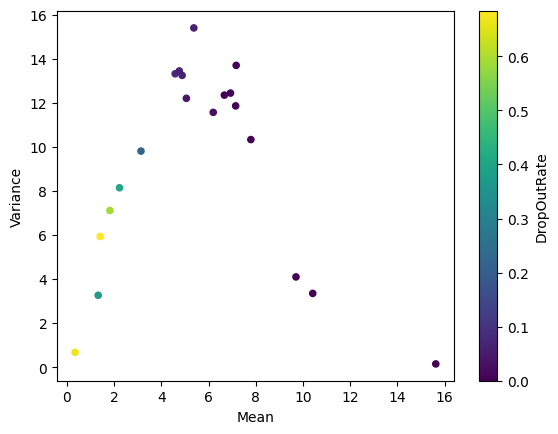

In [37]:
synth_scbool.criteria_.plot.scatter(x="Mean", y="Variance", c="DropOutRate")

In [38]:
def label_of_index(idx):
    return "_".join(idx.split("_")[:-1]) if "_to_" in idx else idx

labels = [label_of_index(idx) for idx in traj_df.index]

color_map_1 = {
    "ES": "#00f7ff", #"#32a899",
    "ES_to_ECTO": "#3277a8",
    "ECTO": "#3252a8",
    "ES_to_MESENDO": "#32a836",
    "MESENDO_to_DEFENDO": "#99a832",
    "MESENDO": "#50822f",
    "DEFENDO": "#dbdb23",
    "MESENDO_to_MESO": "#db7323",
    "MESO": "#c24438",
}

color_map = {
    "init": "#00f7ff", #"#32a899",
    "init_to_stable1": "#3277a8",
    "stable1": "#3252a8",
    "init_to_bifurcation": "#32a836",
    "bifurcation_to_stable3": "#99a832",
    "bifurcation": "#50822f",
    "stable3": "#dbdb23",
    "bifurcation_to_stable2": "#db7323",
    "stable2": "#c24438",
}


assert len(color_map.values()) == len(set(color_map.values())), "Colours are not unique"

In [39]:
sorted(set(labels))

['bifurcation',
 'bifurcation_to_stable2',
 'bifurcation_to_stable3',
 'init',
 'init_to_bifurcation',
 'init_to_stable1',
 'stable1',
 'stable2',
 'stable3']

In [40]:
metadata = [[l, color_map[l]] for i,l in enumerate(labels) for _ in range(n_samples[i])]
metadata = pd.DataFrame(metadata, columns=["label", "label_color"])
metadata.index = counts.index
metadata

,label,label_color
cellID,,
init_0,init,#00f7ff
init_1,init,#00f7ff
init_2,init,#00f7ff
init_3,init,#00f7ff
init_4,init,#00f7ff
...,...,...
stable3_512,stable3,#dbdb23
stable3_513,stable3,#dbdb23
stable3_514,stable3,#dbdb23


In [41]:
EXPORT = False

if EXPORT:
    counts.T.to_csv(checkpoint_dir / "stream_expr_data.tsv", sep="\t")
    metadata.to_csv(checkpoint_dir / "stream_expr_metadata.tsv", sep="\t")

In [42]:
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, TSNE, SpectralEmbedding
from sklearn.pipeline import Pipeline, FunctionTransformer

import matplotlib.pyplot as plt

In [74]:
def rename_columns(df):
    """ """
    df = pd.DataFrame(df, index=metadata.index)
    df.columns = [f"dim{i}" for i in range(df.shape[1])]
    return df

N_COMPONENTS = 3

vis_pipeline = Pipeline([
    ('pca', PCA()),
    ('subset_pca', FunctionTransformer(lambda x: x.iloc[:, :N_COMPONENTS] if isinstance(x, pd.DataFrame) else x[:, ][:, :N_COMPONENTS])),
    ('rename_cols', FunctionTransformer(rename_columns))
])

In [75]:
%time projected = vis_pipeline.fit_transform(counts)

CPU times: user 0 ns, sys: 29.8 ms, total: 29.8 ms
Wall time: 6.08 ms


In [76]:
%time raw_vis_frame = TSNE(perplexity=100, random_state=SEED).fit_transform(projected)

CPU times: user 53.8 s, sys: 198 ms, total: 54 s
Wall time: 54.1 s


In [77]:
vis_frame = rename_columns(raw_vis_frame).join(metadata)

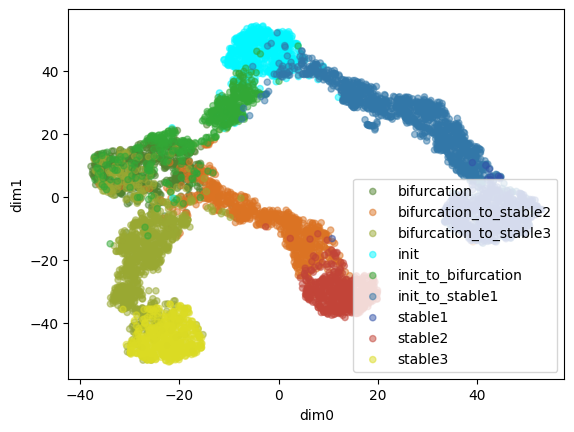

In [78]:
ax = None
for label, frame in vis_frame.groupby('label'):
    scatter_kwargs = dict(x='dim0', y='dim1', label=label, c=frame['label_color'], alpha=.5)
    if ax is not None:
        scatter_kwargs.update({'ax': ax})
    ax = frame.plot.scatter(**scatter_kwargs)


In [79]:
fig = ax.get_figure()

In [80]:
fig.tight_layout()
fig.subplots_adjust(right=0.96)

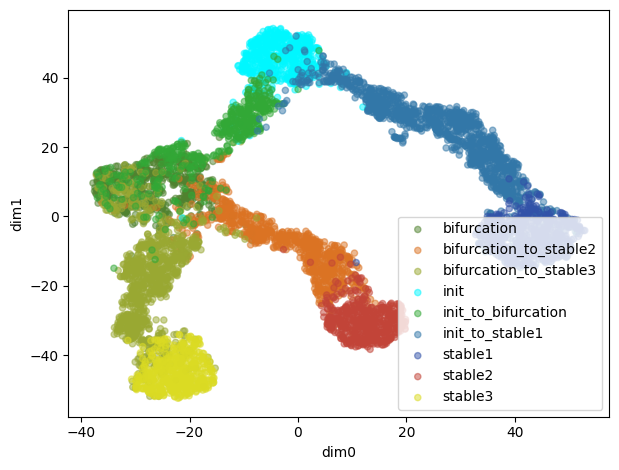

In [81]:
fig

for _f in ['svg', 'pdf', 'png']:
    fig.savefig(f"multilevel_random_network_tsne.{_f}")
